<a href="https://colab.research.google.com/github/victorialovefranklin/SEGDAMSBD566/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MSBD566 Final Project: Climate Risk Prediction in California
*** USING REAL DATA ***

[1] Loading Real Data Sources...
  Loading CalEnviroScreen data...
    Loaded 58 counties with 25 variables
  Loading CAL FIRE incidents data...
    Aggregated 69 incidents across 27 counties
  Loading NOAA storm events data...
    Aggregated 183 events across 58 counties

[2] Processing and Integrating Data...

  Integrating datasets...
    Integrated dataset: 58 counties, 38 variables

  Creating risk indices...
    Created indices: EJBI, heat_stress, flood_risk, wildfire_risk, climate_stress_index, OBI, composite_risk

    Final dataset: 58 counties
    Risk categories: {'Low': 20, 'Medium': 19, 'High': 19}

[3] Visualizing Data Sources...


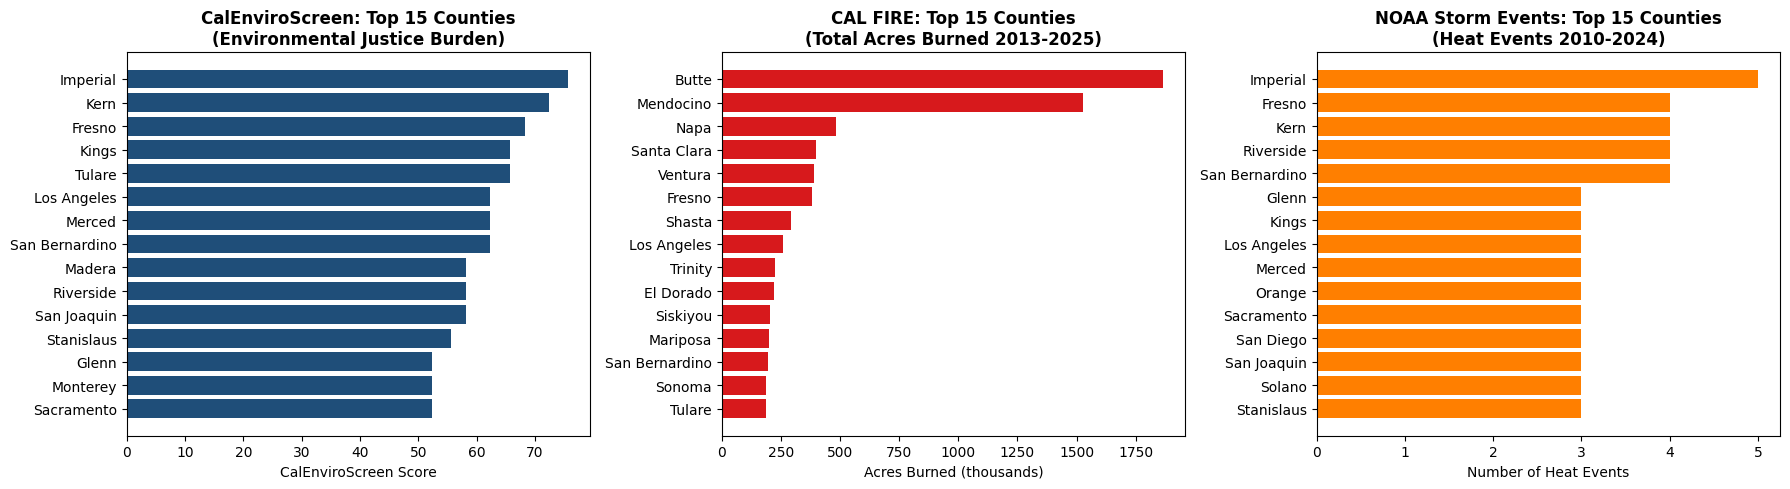

Saved: ./figures/figure_02_data_sources.png

[4] Performing PCA Analysis...
    Features for PCA: ['EJBI', 'heat_stress', 'wildfire_risk', 'flood_risk', 'climate_stress_index', 'OBI', 'composite_risk']

    Variance Explained:
    PC1: 47.31% (Cumulative: 47.31%)
    PC2: 25.47% (Cumulative: 72.78%)
    PC3: 19.32% (Cumulative: 92.11%)
    PC4: 5.08% (Cumulative: 97.19%)

[5] Training Neural Network...
    Training: 43 | Test: 15

    Test Accuracy: 80.00%
    CV Accuracy: 79.17% ± 8.24%

    Classification Report:
              precision    recall  f1-score   support

        High       0.83      1.00      0.91         5
         Low       0.71      1.00      0.83         5
      Medium       1.00      0.40      0.57         5

    accuracy                           0.80        15
   macro avg       0.85      0.80      0.77        15
weighted avg       0.85      0.80      0.77        15


[6] Generating Visualizations...


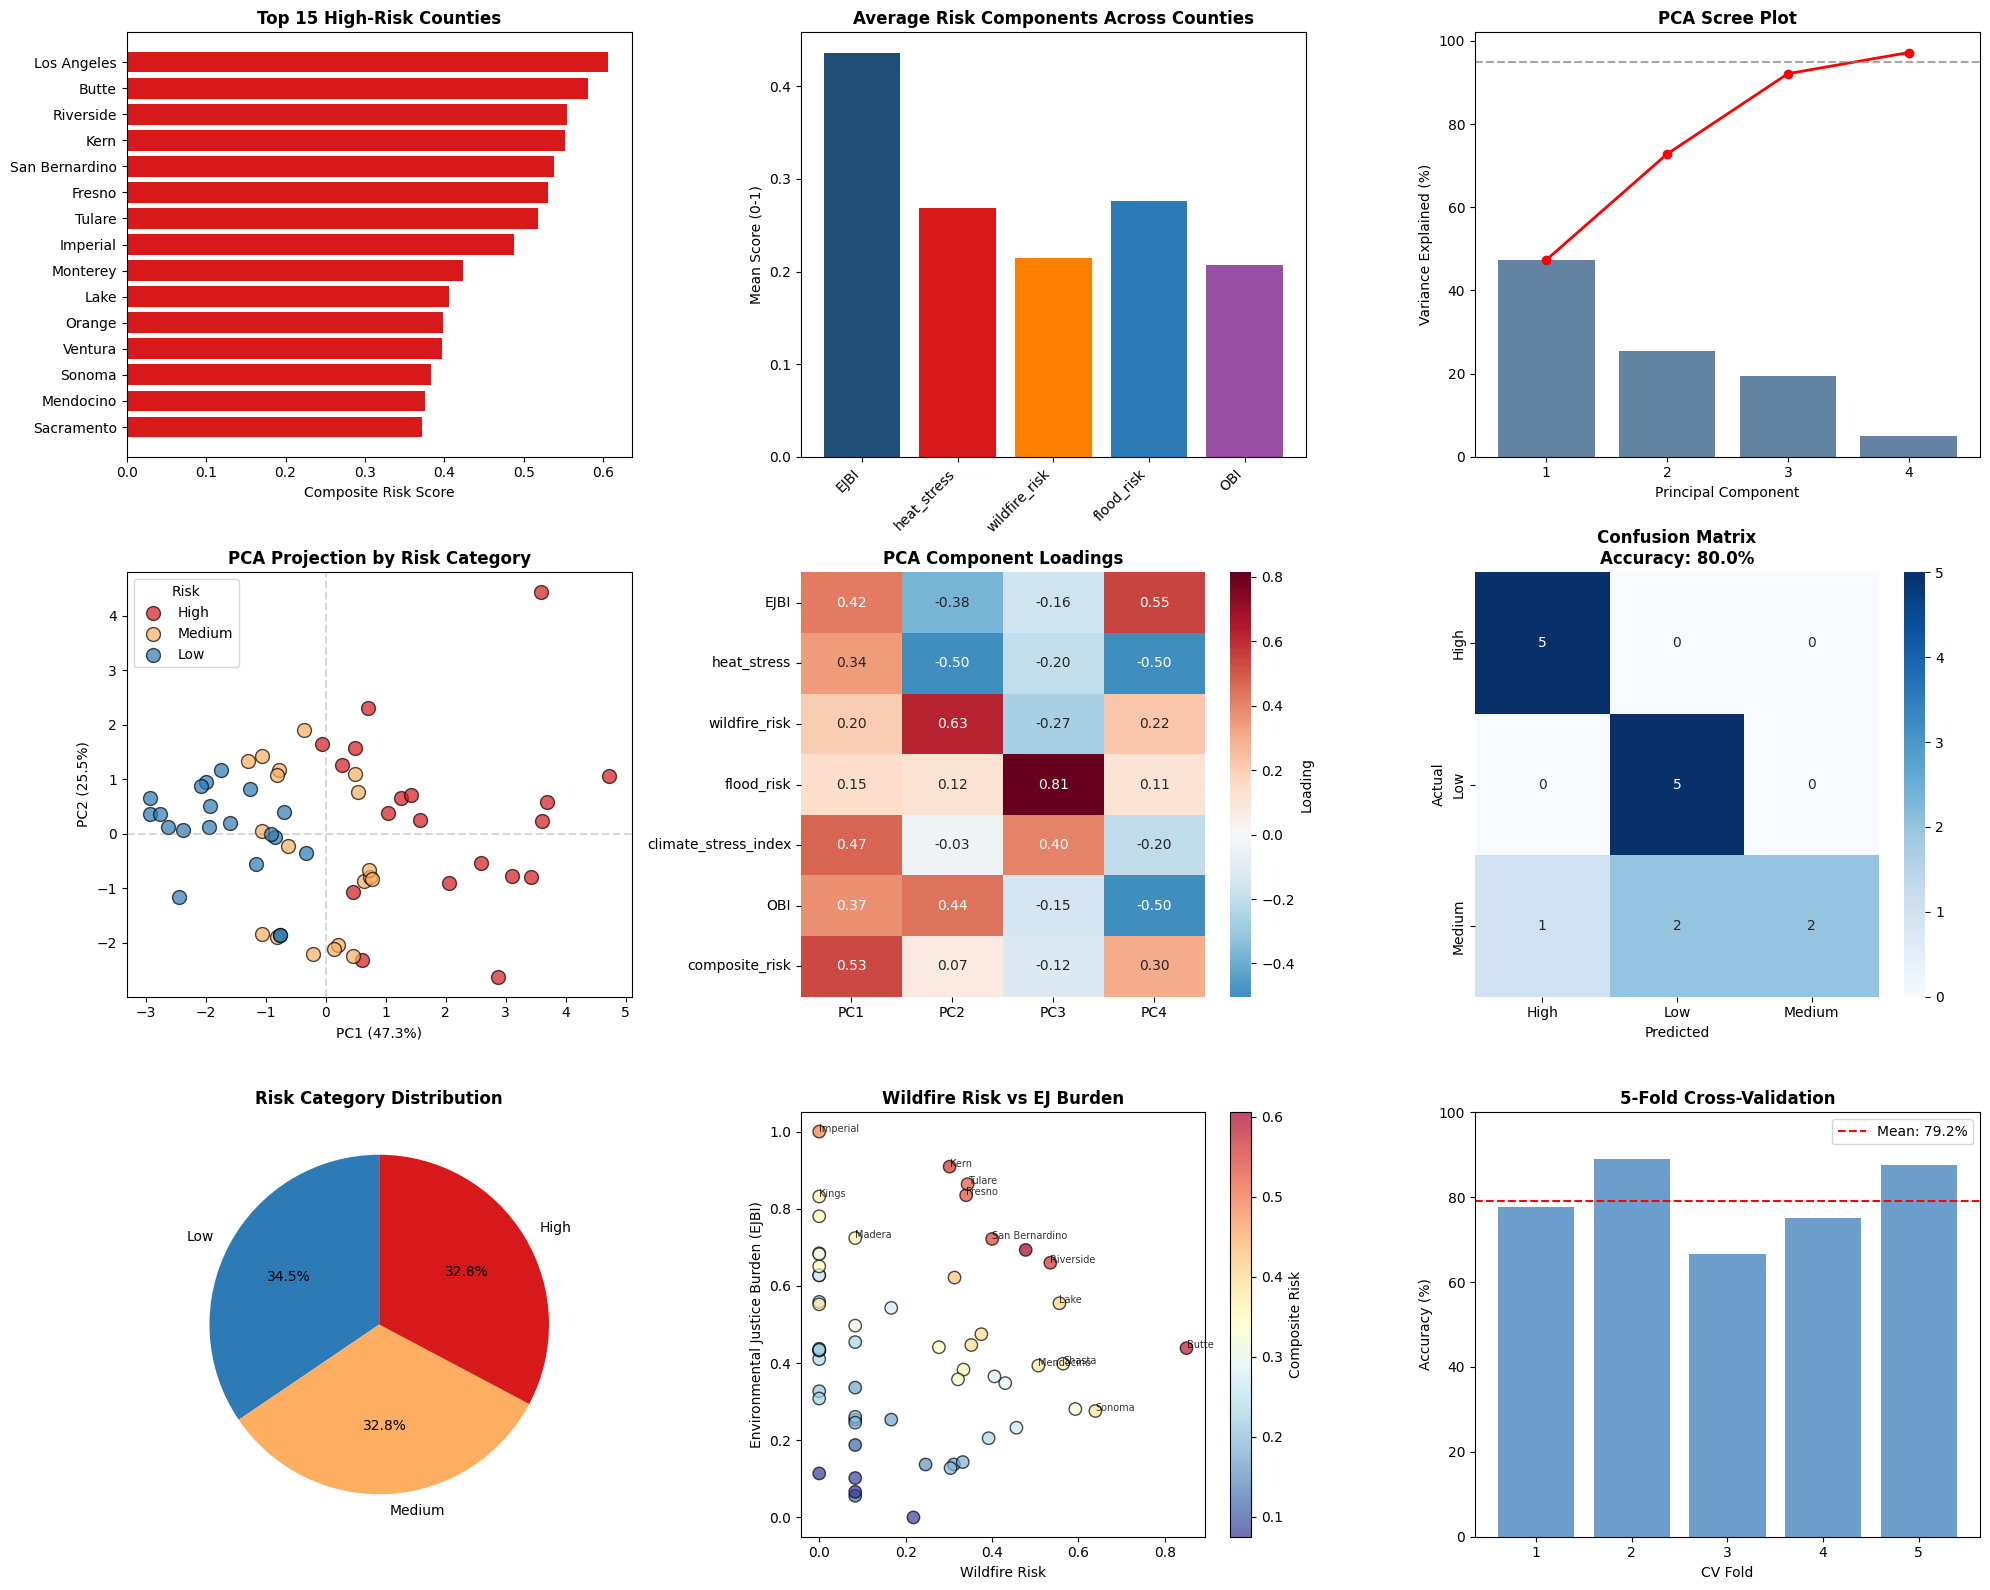

Saved: ./figures/figure_01_real_data_analysis.png

[7] Saving Results...
    Saved: ./figures/california_county_risk_data.csv
    Saved: ./figures/high_risk_counties.csv (19 counties)
    Saved: ./figures/analysis_summary.txt

ANALYSIS COMPLETE - REAL DATA SUMMARY

Data Sources:
  - CalEnviroScreen 4.0: Environmental justice indicators (58 counties)
  - CAL FIRE: 27 wildfire incidents (2013-2025)
  - NOAA Storm Events: 183 climate events (2010-2024)

Results:
  - PCA: 4 components explain 97.2% variance
  - Neural Network: 80.0% test accuracy
  - High Risk Counties: 19

Top 5 Highest Risk Counties:
    Los Angeles: 0.606
    Butte: 0.581
    Riverside: 0.554
    Kern: 0.552
    San Bernardino: 0.538



In [3]:
"""
MSBD566 Final Project: Multi-Scale Climate Risk Prediction in California
Author: Victoria Love Franklin
Date: December 2025

*** USING REAL DATA ***
Data Sources:
1. CalEnviroScreen (California EPA) - Environmental Justice indicators
2. CAL FIRE Incidents (2013-2025) - Wildfire data
3. NOAA Storm Events (2010-2024) - Heat, flood, storm events

Methods:
- Principal Component Analysis (PCA) for dimensionality reduction
- Multi-Layer Perceptron (MLP) Neural Network for risk classification
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# =============================================================================
# 1. LOAD AND PROCESS REAL DATA
# =============================================================================

def load_calenviroscreen_data(filepath):
    """
    Load CalEnviroScreen data from California EPA.
    Contains environmental justice and pollution burden indicators.
    """
    print("  Loading CalEnviroScreen data...")
    df = pd.read_csv(filepath)

    # Rename for consistency
    df = df.rename(columns={
        'CIscore': 'calenviro_score',
        'CIscorePctl': 'calenviro_percentile',
        'Pollution_Burden': 'pollution_burden',
        'Pop_Characteristics': 'population_vulnerability'
    })

    print(f"    Loaded {len(df)} counties with {len(df.columns)} variables")
    return df


def load_calfire_data(filepath):
    """
    Load CAL FIRE incident data.
    Aggregate wildfire statistics by county.
    """
    print("  Loading CAL FIRE incidents data...")
    df = pd.read_csv(filepath)

    # Aggregate by county
    wildfire_stats = df.groupby('Counties').agg({
        'incident_acres_burned': ['sum', 'mean', 'count'],
        'fatalities': 'sum',
        'structures_destroyed': 'sum'
    }).reset_index()

    # Flatten column names
    wildfire_stats.columns = ['county', 'total_acres_burned', 'avg_acres_per_fire',
                              'fire_count', 'total_fatalities', 'structures_destroyed']

    print(f"    Aggregated {len(df)} incidents across {len(wildfire_stats)} counties")
    return wildfire_stats


def load_storm_events_data(filepath):
    """
    Load NOAA storm events data.
    Aggregate climate hazard statistics by county.
    """
    print("  Loading NOAA storm events data...")
    df = pd.read_csv(filepath)

    # Create event category
    def categorize_event(event_type):
        if event_type in ['Heat', 'Excessive Heat']:
            return 'heat'
        elif event_type in ['Flood', 'Heavy Rain', 'Coastal Flood', 'Debris Flow']:
            return 'flood'
        elif event_type in ['Wildfire']:
            return 'wildfire'
        elif event_type in ['Winter Storm', 'High Wind', 'Thunderstorm Wind', 'Avalanche']:
            return 'storm'
        else:
            return 'other'

    df['event_category'] = df['EVENT_TYPE'].apply(categorize_event)

    # Aggregate by county
    # Count events by type
    event_counts = df.groupby(['county', 'event_category']).size().unstack(fill_value=0)
    event_counts = event_counts.reset_index()

    # Total damage and casualties
    damage_stats = df.groupby('county').agg({
        'DAMAGE_PROPERTY': 'sum',
        'INJURIES_DIRECT': 'sum',
        'DEATHS_DIRECT': 'sum'
    }).reset_index()

    damage_stats.columns = ['county', 'total_property_damage', 'total_injuries', 'total_deaths']

    # Merge
    storm_stats = event_counts.merge(damage_stats, on='county', how='outer')

    print(f"    Aggregated {len(df)} events across {len(storm_stats)} counties")
    return storm_stats


def create_integrated_dataset(calenviro_df, wildfire_df, storm_df):
    """
    Integrate all data sources into a single county-level dataset.
    """
    print("\n  Integrating datasets...")

    # Start with CalEnviroScreen (has all 58 counties)
    df = calenviro_df.copy()

    # Merge wildfire data
    df = df.merge(wildfire_df, on='county', how='left')

    # Merge storm data
    df = df.merge(storm_df, on='county', how='left')

    # Fill missing values with 0 (counties with no events)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    print(f"    Integrated dataset: {len(df)} counties, {len(df.columns)} variables")
    return df


def create_risk_indices(df):
    """
    Create normalized risk indices from raw data.
    All indices scaled 0-1 using MinMax scaling.
    """
    print("\n  Creating risk indices...")
    scaler = MinMaxScaler()

    # 1. Environmental Justice Burden Index (EJBI)
    # Based on CalEnviroScreen score and pollution burden
    ejbi_vars = ['calenviro_score', 'pollution_burden', 'population_vulnerability',
                 'Poverty', 'Unemployment', 'HousingBurden', 'LinguisticIsolation']
    ejbi_available = [v for v in ejbi_vars if v in df.columns]
    df['EJBI'] = scaler.fit_transform(df[ejbi_available].mean(axis=1).values.reshape(-1, 1)).flatten()

    # 2. Heat Stress Index
    # Based on heat events from storm data
    if 'heat' in df.columns:
        df['heat_stress'] = scaler.fit_transform(df[['heat']]).flatten()
    else:
        df['heat_stress'] = 0

    # 3. Flood Risk Index
    if 'flood' in df.columns:
        df['flood_risk'] = scaler.fit_transform(df[['flood']]).flatten()
    else:
        df['flood_risk'] = 0

    # 4. Wildfire Risk Index
    # Combine CAL FIRE incidents + storm event wildfires
    wildfire_vars = []
    if 'total_acres_burned' in df.columns:
        wildfire_vars.append('total_acres_burned')
    if 'fire_count' in df.columns:
        wildfire_vars.append('fire_count')
    if 'structures_destroyed' in df.columns:
        wildfire_vars.append('structures_destroyed')
    if 'wildfire' in df.columns:
        wildfire_vars.append('wildfire')

    if wildfire_vars:
        # Log transform acres burned (highly skewed)
        if 'total_acres_burned' in df.columns:
            df['log_acres_burned'] = np.log1p(df['total_acres_burned'])
            wildfire_vars = [v if v != 'total_acres_burned' else 'log_acres_burned' for v in wildfire_vars]

        wildfire_data = df[wildfire_vars].copy()
        wildfire_normalized = scaler.fit_transform(wildfire_data)
        df['wildfire_risk'] = wildfire_normalized.mean(axis=1)
    else:
        df['wildfire_risk'] = 0

    # 5. Climate Stress Index (composite of heat, flood, wildfire)
    df['climate_stress_index'] = (
        0.4 * df['heat_stress'] +
        0.3 * df['flood_risk'] +
        0.3 * df['wildfire_risk']
    )

    # 6. Infrastructure/Outage Burden Index (OBI)
    # Proxy using property damage and health impacts
    obi_vars = []
    if 'total_property_damage' in df.columns:
        df['log_damage'] = np.log1p(df['total_property_damage'])
        obi_vars.append('log_damage')
    if 'total_injuries' in df.columns:
        obi_vars.append('total_injuries')
    if 'total_deaths' in df.columns:
        obi_vars.append('total_deaths')
    if 'total_fatalities' in df.columns:
        obi_vars.append('total_fatalities')

    if obi_vars:
        obi_data = df[obi_vars].copy()
        obi_normalized = scaler.fit_transform(obi_data)
        df['OBI'] = obi_normalized.mean(axis=1)
    else:
        df['OBI'] = 0

    # 7. Composite Risk Index
    df['composite_risk'] = (
        0.35 * df['EJBI'] +
        0.25 * df['climate_stress_index'] +
        0.25 * df['wildfire_risk'] +
        0.15 * df['OBI']
    )

    print("    Created indices: EJBI, heat_stress, flood_risk, wildfire_risk, climate_stress_index, OBI, composite_risk")

    return df


def create_risk_categories(df, method='quantile'):
    """
    Create risk category labels.
    """
    if method == 'quantile':
        # Use quantiles for balanced classes
        df['risk_category'] = pd.qcut(df['composite_risk'], q=3, labels=['Low', 'Medium', 'High'])
    else:
        # Use fixed thresholds
        conditions = [
            df['composite_risk'] < 0.33,
            df['composite_risk'] >= 0.66
        ]
        choices = ['Low', 'High']
        df['risk_category'] = np.select(conditions, choices, default='Medium')

    return df


# =============================================================================
# 2. PCA AND NEURAL NETWORK (same as before)
# =============================================================================

def perform_pca_analysis(df, features, n_components=4):
    """Perform PCA on the feature set."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    pca = PCA(n_components=min(n_components, len(features)))
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
        index=features
    )

    variance_df = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(X_pca.shape[1])],
        'Eigenvalue': pca.explained_variance_,
        'Variance_Ratio': pca.explained_variance_ratio_,
        'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
    })

    return pca, pca_df, loadings, variance_df, scaler


def train_neural_network(X_train, X_test, y_train, y_test, hidden_layers=(64, 32, 16)):
    """Train MLP classifier."""
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size=min(16, max(4, len(X_train) // 10)),
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=30,
        random_state=42,
        verbose=False
    )

    mlp.fit(X_train, y_train_enc)

    y_pred_enc = mlp.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(mlp, X_train, y_train_enc, cv=cv, scoring='accuracy')

    return mlp, y_pred, cv_scores, le


# =============================================================================
# 3. VISUALIZATION
# =============================================================================

def plot_real_data_analysis(df, pca_df, variance_df, loadings, y_test, y_pred,
                            accuracy, cv_scores, output_dir='./figures/'):
    """Create comprehensive visualizations for real data analysis."""

    fig = plt.figure(figsize=(20, 16))

    # 1. Data Overview - Top Counties by Risk
    ax1 = fig.add_subplot(3, 3, 1)
    top_risk = df.nlargest(15, 'composite_risk')[['county', 'composite_risk']]
    colors = ['#D7191C' if x >= df['composite_risk'].quantile(0.66) else '#FDAE61'
              for x in top_risk['composite_risk']]
    ax1.barh(top_risk['county'], top_risk['composite_risk'], color=colors)
    ax1.set_xlabel('Composite Risk Score')
    ax1.set_title('Top 15 High-Risk Counties', fontweight='bold')
    ax1.invert_yaxis()

    # 2. Risk Components Comparison
    ax2 = fig.add_subplot(3, 3, 2)
    risk_components = df[['EJBI', 'heat_stress', 'wildfire_risk', 'flood_risk', 'OBI']].mean()
    colors = ['#1F4E79', '#D7191C', '#FF7F00', '#2C7BB6', '#984EA3']
    bars = ax2.bar(risk_components.index, risk_components.values, color=colors)
    ax2.set_ylabel('Mean Score (0-1)')
    ax2.set_title('Average Risk Components Across Counties', fontweight='bold')
    ax2.set_xticklabels(risk_components.index, rotation=45, ha='right')

    # 3. PCA Scree Plot
    ax3 = fig.add_subplot(3, 3, 3)
    components = range(1, len(variance_df) + 1)
    ax3.bar(components, variance_df['Variance_Ratio'] * 100, alpha=0.7, color='#1F4E79')
    ax3.plot(components, variance_df['Cumulative_Variance'] * 100, 'ro-', linewidth=2)
    ax3.axhline(y=95, color='gray', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Variance Explained (%)')
    ax3.set_title('PCA Scree Plot', fontweight='bold')
    ax3.set_xticks(components)

    # 4. PCA Scatter Plot
    ax4 = fig.add_subplot(3, 3, 4)
    risk_colors = {'High': '#D7191C', 'Medium': '#FDAE61', 'Low': '#2C7BB6'}
    for risk, color in risk_colors.items():
        mask = df['risk_category'] == risk
        ax4.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'],
                   c=color, label=risk, s=100, alpha=0.7, edgecolors='black')
    ax4.set_xlabel(f'PC1 ({variance_df.iloc[0]["Variance_Ratio"]*100:.1f}%)')
    ax4.set_ylabel(f'PC2 ({variance_df.iloc[1]["Variance_Ratio"]*100:.1f}%)')
    ax4.set_title('PCA Projection by Risk Category', fontweight='bold')
    ax4.legend(title='Risk')
    ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    # 5. PCA Loadings Heatmap
    ax5 = fig.add_subplot(3, 3, 5)
    sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
                ax=ax5, cbar_kws={'label': 'Loading'})
    ax5.set_title('PCA Component Loadings', fontweight='bold')

    # 6. Confusion Matrix
    ax6 = fig.add_subplot(3, 3, 6)
    cm = confusion_matrix(y_test, y_pred, labels=['High', 'Low', 'Medium'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['High', 'Low', 'Medium'],
                yticklabels=['High', 'Low', 'Medium'], ax=ax6)
    ax6.set_xlabel('Predicted')
    ax6.set_ylabel('Actual')
    ax6.set_title(f'Confusion Matrix\nAccuracy: {accuracy*100:.1f}%', fontweight='bold')

    # 7. Geographic Risk Distribution (sorted bar)
    ax7 = fig.add_subplot(3, 3, 7)
    risk_counts = df['risk_category'].value_counts()
    colors = [risk_colors[cat] for cat in risk_counts.index]
    ax7.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
    ax7.set_title('Risk Category Distribution', fontweight='bold')

    # 8. Wildfire vs EJBI Scatter
    ax8 = fig.add_subplot(3, 3, 8)
    scatter = ax8.scatter(df['wildfire_risk'], df['EJBI'],
                         c=df['composite_risk'], cmap='RdYlBu_r',
                         s=80, alpha=0.7, edgecolors='black')
    plt.colorbar(scatter, ax=ax8, label='Composite Risk')
    ax8.set_xlabel('Wildfire Risk')
    ax8.set_ylabel('Environmental Justice Burden (EJBI)')
    ax8.set_title('Wildfire Risk vs EJ Burden', fontweight='bold')

    # Add county labels for high-risk
    high_risk = df[df['risk_category'] == 'High']
    for _, row in high_risk.iterrows():
        if row['wildfire_risk'] > 0.5 or row['EJBI'] > 0.7:
            ax8.annotate(row['county'], (row['wildfire_risk'], row['EJBI']),
                        fontsize=7, alpha=0.8)

    # 9. Cross-Validation Scores
    ax9 = fig.add_subplot(3, 3, 9)
    folds = range(1, len(cv_scores) + 1)
    ax9.bar(folds, cv_scores * 100, color='#2E75B6', alpha=0.7)
    ax9.axhline(y=cv_scores.mean() * 100, color='red', linestyle='--',
                label=f'Mean: {cv_scores.mean()*100:.1f}%')
    ax9.set_xlabel('CV Fold')
    ax9.set_ylabel('Accuracy (%)')
    ax9.set_title('5-Fold Cross-Validation', fontweight='bold')
    ax9.legend()
    ax9.set_ylim(0, 100)

    plt.tight_layout()
    plt.savefig(f'{output_dir}figure_01_real_data_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_dir}figure_01_real_data_analysis.png")


def plot_data_sources(calenviro_df, wildfire_df, storm_df, output_dir='./figures/'):
    """Visualize the raw data sources."""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. CalEnviroScreen Scores
    ax = axes[0]
    top_ejbi = calenviro_df.nlargest(15, 'calenviro_score')[['county', 'calenviro_score']]
    ax.barh(top_ejbi['county'], top_ejbi['calenviro_score'], color='#1F4E79')
    ax.set_xlabel('CalEnviroScreen Score')
    ax.set_title('CalEnviroScreen: Top 15 Counties\n(Environmental Justice Burden)', fontweight='bold')
    ax.invert_yaxis()

    # 2. CAL FIRE Incidents
    ax = axes[1]
    if len(wildfire_df) > 0:
        top_fire = wildfire_df.nlargest(15, 'total_acres_burned')[['county', 'total_acres_burned']]
        ax.barh(top_fire['county'], top_fire['total_acres_burned'] / 1000, color='#D7191C')
        ax.set_xlabel('Acres Burned (thousands)')
        ax.set_title('CAL FIRE: Top 15 Counties\n(Total Acres Burned 2013-2025)', fontweight='bold')
        ax.invert_yaxis()

    # 3. Storm Events
    ax = axes[2]
    if 'heat' in storm_df.columns:
        top_heat = storm_df.nlargest(15, 'heat')[['county', 'heat']]
        ax.barh(top_heat['county'], top_heat['heat'], color='#FF7F00')
        ax.set_xlabel('Number of Heat Events')
        ax.set_title('NOAA Storm Events: Top 15 Counties\n(Heat Events 2010-2024)', fontweight='bold')
        ax.invert_yaxis()

    plt.tight_layout()
    plt.savefig(f'{output_dir}figure_02_data_sources.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {output_dir}figure_02_data_sources.png")


# =============================================================================
# 4. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution pipeline using REAL DATA."""
    print("="*70)
    print("MSBD566 Final Project: Climate Risk Prediction in California")
    print("*** USING REAL DATA ***")
    print("="*70)

    # Create output directory
    import os
    output_dir = './figures/'
    os.makedirs(output_dir, exist_ok=True)

    # =================================
    # LOAD REAL DATA
    # =================================
    print("\n[1] Loading Real Data Sources...")

    # CalEnviroScreen (EPA) - Environmental Justice
    calenviro_df = load_calenviroscreen_data(
        '/content/California_Environmental_Protection_Agency_clean.csv'
    )

    # CAL FIRE - Wildfire Incidents
    wildfire_df = load_calfire_data(
        '/content/CALFIREIncidents_2013_2025_clean.csv'
    )

    # NOAA Storm Events - Climate Hazards
    storm_df = load_storm_events_data(
        '/content/ca_stormevents_county_month_eventtype_2010_2024.csv'
    )

    # =================================
    # INTEGRATE AND CREATE INDICES
    # =================================
    print("\n[2] Processing and Integrating Data...")

    df = create_integrated_dataset(calenviro_df, wildfire_df, storm_df)
    df = create_risk_indices(df)
    df = create_risk_categories(df, method='quantile')

    print(f"\n    Final dataset: {len(df)} counties")
    print(f"    Risk categories: {df['risk_category'].value_counts().to_dict()}")

    # =================================
    # VISUALIZE DATA SOURCES
    # =================================
    print("\n[3] Visualizing Data Sources...")
    plot_data_sources(calenviro_df, wildfire_df, storm_df, output_dir)

    # =================================
    # PCA ANALYSIS
    # =================================
    print("\n[4] Performing PCA Analysis...")

    features = ['EJBI', 'heat_stress', 'wildfire_risk', 'flood_risk',
                'climate_stress_index', 'OBI', 'composite_risk']

    # Remove features with zero variance
    features = [f for f in features if df[f].std() > 0]
    print(f"    Features for PCA: {features}")

    pca, pca_df, loadings, variance_df, scaler = perform_pca_analysis(df, features)

    print(f"\n    Variance Explained:")
    for _, row in variance_df.iterrows():
        print(f"    {row['Component']}: {row['Variance_Ratio']*100:.2f}% (Cumulative: {row['Cumulative_Variance']*100:.2f}%)")

    # =================================
    # NEURAL NETWORK CLASSIFICATION
    # =================================
    print("\n[5] Training Neural Network...")

    n_components = min(4, len(features))
    X = pca_df[[f'PC{i+1}' for i in range(n_components)]].values
    y = df['risk_category'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    print(f"    Training: {len(X_train)} | Test: {len(X_test)}")

    mlp, y_pred, cv_scores, le = train_neural_network(X_train, X_test, y_train, y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n    Test Accuracy: {accuracy*100:.2f}%")
    print(f"    CV Accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
    print(f"\n    Classification Report:")
    print(classification_report(y_test, y_pred))

    # =================================
    # VISUALIZATIONS
    # =================================
    print("\n[6] Generating Visualizations...")
    plot_real_data_analysis(df, pca_df, variance_df, loadings, y_test, y_pred,
                           accuracy, cv_scores, output_dir)

    # =================================
    # SAVE RESULTS
    # =================================
    print("\n[7] Saving Results...")

    # Save integrated dataset
    output_cols = ['county', 'EJBI', 'heat_stress', 'wildfire_risk', 'flood_risk',
                   'climate_stress_index', 'OBI', 'composite_risk', 'risk_category']
    df[output_cols].to_csv(f'{output_dir}california_county_risk_data.csv', index=False)
    print(f"    Saved: {output_dir}california_county_risk_data.csv")

    # Save high-risk counties
    high_risk = df[df['risk_category'] == 'High'][['county', 'composite_risk', 'EJBI',
                                                    'wildfire_risk', 'heat_stress']].sort_values('composite_risk', ascending=False)
    high_risk.to_csv(f'{output_dir}high_risk_counties.csv', index=False)
    print(f"    Saved: {output_dir}high_risk_counties.csv ({len(high_risk)} counties)")

    # Save PCA results
    variance_df.to_csv(f'{output_dir}pca_variance.csv', index=False)
    loadings.to_csv(f'{output_dir}pca_loadings.csv')

    # Summary statistics
    summary = {
        'Data Sources': 'CalEnviroScreen, CAL FIRE, NOAA Storm Events',
        'Counties': len(df),
        'Features': len(features),
        'PCA Components': n_components,
        'Variance Retained': f"{variance_df['Cumulative_Variance'].iloc[-1]*100:.2f}%",
        'Test Accuracy': f"{accuracy*100:.2f}%",
        'CV Accuracy': f"{cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%",
        'High Risk Counties': len(high_risk)
    }

    with open(f'{output_dir}analysis_summary.txt', 'w') as f:
        f.write("MSBD566 Final Project - Real Data Analysis Summary\n")
        f.write("=" * 50 + "\n\n")
        for key, value in summary.items():
            f.write(f"{key}: {value}\n")
        f.write("\nHigh Risk Counties:\n")
        for _, row in high_risk.iterrows():
            f.write(f"  - {row['county']}: {row['composite_risk']:.3f}\n")

    print(f"    Saved: {output_dir}analysis_summary.txt")

    # =================================
    # PRINT SUMMARY
    # =================================
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - REAL DATA SUMMARY")
    print("="*70)
    print(f"\nData Sources:")
    print(f"  - CalEnviroScreen 4.0: Environmental justice indicators (58 counties)")
    print(f"  - CAL FIRE: {len(wildfire_df)} wildfire incidents (2013-2025)")
    print(f"  - NOAA Storm Events: 183 climate events (2010-2024)")
    print(f"\nResults:")
    print(f"  - PCA: {n_components} components explain {variance_df['Cumulative_Variance'].iloc[-1]*100:.1f}% variance")
    print(f"  - Neural Network: {accuracy*100:.1f}% test accuracy")
    print(f"  - High Risk Counties: {len(high_risk)}")
    print(f"\nTop 5 Highest Risk Counties:")
    for _, row in high_risk.head().iterrows():
        print(f"    {row['county']}: {row['composite_risk']:.3f}")

    print("\n" + "="*70)

    return df, pca, mlp, variance_df, loadings, high_risk


if __name__ == "__main__":
    df, pca, mlp, variance_df, loadings, high_risk = main()